# Assignment 2, ECE9309 Machine Learning

### Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Question 3 

## Attempt of LSTM neural net
## 4 hidden layers 

In [2]:
# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

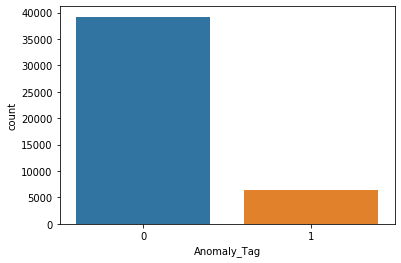

In [3]:
# read input data

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# separate the anomaly tags
true_labels = pd.DataFrame(df_anomaly['Anomaly_Tag'])

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
sns.countplot(x = 'Anomaly_Tag', data=true_labels)

In [4]:
# Do our train / test splitting (80/20)

input_train, input_test, output_train, output_test = train_test_split(df_anomaly, true_labels, test_size=0.2, random_state=30)

print("input_train: ")
print(input_train.describe())
print("\n")
print("input_train: ")
print(input_test.describe())

input_train: 
                 X1            X2            X3            X4            X5  \
count  36500.000000  36500.000000  36500.000000  36500.000000  36500.000000   
mean       0.635594      1.843927     27.055131     16.063809      0.613836   
std        0.241495      2.405368     67.903168     78.437691      0.363696   
min        0.299160      0.670490      4.793800      1.203300      0.217050   
25%        0.475428      0.977568      8.047400      1.896600      0.429127   
50%        0.570090      1.181600     13.046500      2.245400      0.521515   
75%        0.722232      1.778800     22.015000      2.990025      0.668713   
max        3.076400     49.905000   1044.100000   1153.200000      7.096300   

                 X6            X7            X8  
count  36500.000000  36500.000000  36500.000000  
mean       1.640104     16.842250      3.989066  
std        2.208301     28.276834     18.535098  
min        0.561330      3.187000      1.056600  
25%        0.903765     

In [5]:
# scale the inputs such that mean = 0, and standard deviation = 1
scaler = StandardScaler()

input_train = scaler.fit_transform(input_train)
input_test = scaler.fit_transform(input_test)

input_train_df = pd.DataFrame(input_train)
input_test_df = pd.DataFrame(input_test)
print("input_train: ")
print(input_train_df.describe())
print("\n")
print("input_train: ")
print(input_test_df.describe())

input_train: 
                  0             1             2             3             4  \
count  3.650000e+04  3.650000e+04  3.650000e+04  3.650000e+04  3.650000e+04   
mean   8.660348e-17  2.161437e-17 -1.226720e-17  2.918290e-17 -8.871594e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -1.393147e+00 -4.878476e-01 -3.278438e-01 -1.894588e-01 -1.090997e+00   
25%   -6.632375e-01 -3.601824e-01 -2.799279e-01 -1.806198e-01 -5.078717e-01   
50%   -2.712475e-01 -2.753574e-01 -2.063059e-01 -1.761729e-01 -2.538444e-01   
75%    3.587626e-01 -2.707602e-02 -7.422628e-02 -1.666796e-01  1.508876e-01   
max    1.010719e+01  1.998103e+01  1.497808e+01  1.449752e+01  1.782409e+01   

                  5             6             7  
count  3.650000e+04  3.650000e+04  3.650000e+04  
mean   1.089463e-16  1.154875e-16 -2.384394e-17  
std    1.000014e+00  1.000014e+00  1.000014e+00  
min   -4.885153e-01 -4.829196e-01 -1.582137e-01  
25%   -3.334460e-01 -3.3

In [6]:
# these are hyper parameters. will need to be played with later! 

epochs = 75
batch_size = 128
lr = 0.001

In [7]:
# define out training data class 

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


# call the training class to store our data     
train_data = trainData(torch.FloatTensor(input_train), 
                       torch.FloatTensor(output_train.to_numpy()))


In [8]:
# define the class to store our test data

## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
# call the test data class 
test_data = testData(torch.FloatTensor(input_test))

In [9]:
# define our data loaders 

# use batches of 64 for the training data, also make sure to shuffle data 
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# use batche of 1 for the test data 
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [10]:
# define our binary classification neural net! 

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(32)
        self.batchnorm5 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # Apply ReLu activation of output layer 3 
        x = self.relu(self.layer_3(x))
        
        # apply batchnorm
        x = self.batchnorm3(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # Apply ReLu activation of output layer 4
        x = self.relu(self.layer_4(x))
        
        # apply batchnorm
        x = self.batchnorm4(x)
        
        # apply dropout
        x=self.dropout(x)
        
         # Apply ReLu activation of output layer 5
        x = self.relu(self.layer_5(x))
        
        # apply batchnorm
        x = self.batchnorm5(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [11]:
# see what device you can use (GPU OR CPU)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
# instantiate our model class 
model = binaryClassification()

# evaluate the model using available devices 
model.to(device)
print(model)

# define our loss fucntion BCE = binary cross entropy 
criterion = nn.BCEWithLogitsLoss()

# define our optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr)

binaryClassification(
  (layer_1): Linear(in_features=8, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_5): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
# define the training function Gives back accuracy ! 

def binary_acc(y_pred, y_test):
    
    # perform sigmoid function on our y_predicted 
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    # calculate the amount of correct prediction
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    
    # get the accuracy by dividing by the total amount of tests and multiply by 100
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
# train the model!! 
epoch_loss_list = []
epoch_acc_list = []

model.train()
for e in range(1, epochs+1):
    # get rid of last epcho loss and accuracy measurements
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        # load the xtrain data and ytrain data to device 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # reset the optimizer to zero
        optimizer.zero_grad()
        
        # make the prediction 
        y_pred = model(X_batch)
        
        # apply the loss criterion based on y_predict and y_batch 
        loss = criterion(y_pred, y_batch)
        
        # calculate the accuracy 
        acc = binary_acc(y_pred, y_batch)
        
        # apply backwards propagation (LSTM model)
        loss.backward()
        
        # have the optimizer take a step
        optimizer.step()
        
        # get loss and accuracy items 
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # print the results
    epoch_loss_list.append(epoch_loss/len(train_loader))
    epoch_acc_list.append(epoch_acc/len(train_loader))
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.46717 | Acc: 84.780
Epoch 002: | Loss: 0.29157 | Acc: 88.934
Epoch 003: | Loss: 0.25746 | Acc: 89.622
Epoch 004: | Loss: 0.24230 | Acc: 90.262
Epoch 005: | Loss: 0.23314 | Acc: 90.399
Epoch 006: | Loss: 0.22301 | Acc: 90.822
Epoch 007: | Loss: 0.21464 | Acc: 91.178
Epoch 008: | Loss: 0.20757 | Acc: 91.448
Epoch 009: | Loss: 0.20395 | Acc: 91.608
Epoch 010: | Loss: 0.19739 | Acc: 91.958
Epoch 011: | Loss: 0.19352 | Acc: 91.993
Epoch 012: | Loss: 0.18918 | Acc: 92.112
Epoch 013: | Loss: 0.18260 | Acc: 92.364
Epoch 014: | Loss: 0.17707 | Acc: 92.671
Epoch 015: | Loss: 0.17565 | Acc: 92.839
Epoch 016: | Loss: 0.17113 | Acc: 93.028
Epoch 017: | Loss: 0.16845 | Acc: 93.178
Epoch 018: | Loss: 0.16087 | Acc: 93.430
Epoch 019: | Loss: 0.15726 | Acc: 93.580
Epoch 020: | Loss: 0.15524 | Acc: 93.531
Epoch 021: | Loss: 0.15536 | Acc: 93.545
Epoch 022: | Loss: 0.14916 | Acc: 93.871
Epoch 023: | Loss: 0.14638 | Acc: 93.962
Epoch 024: | Loss: 0.14314 | Acc: 93.990
Epoch 025: | Los

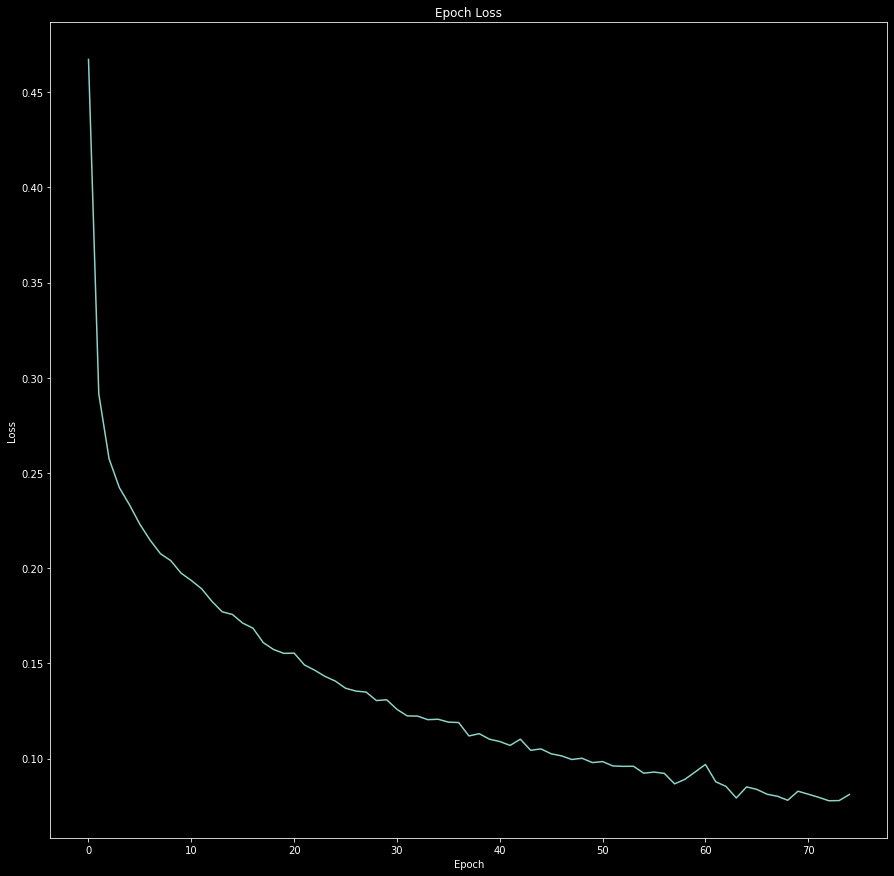

In [15]:
# plot epoch loss
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(epoch_loss_list)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title("Epoch Loss")
plt.show()

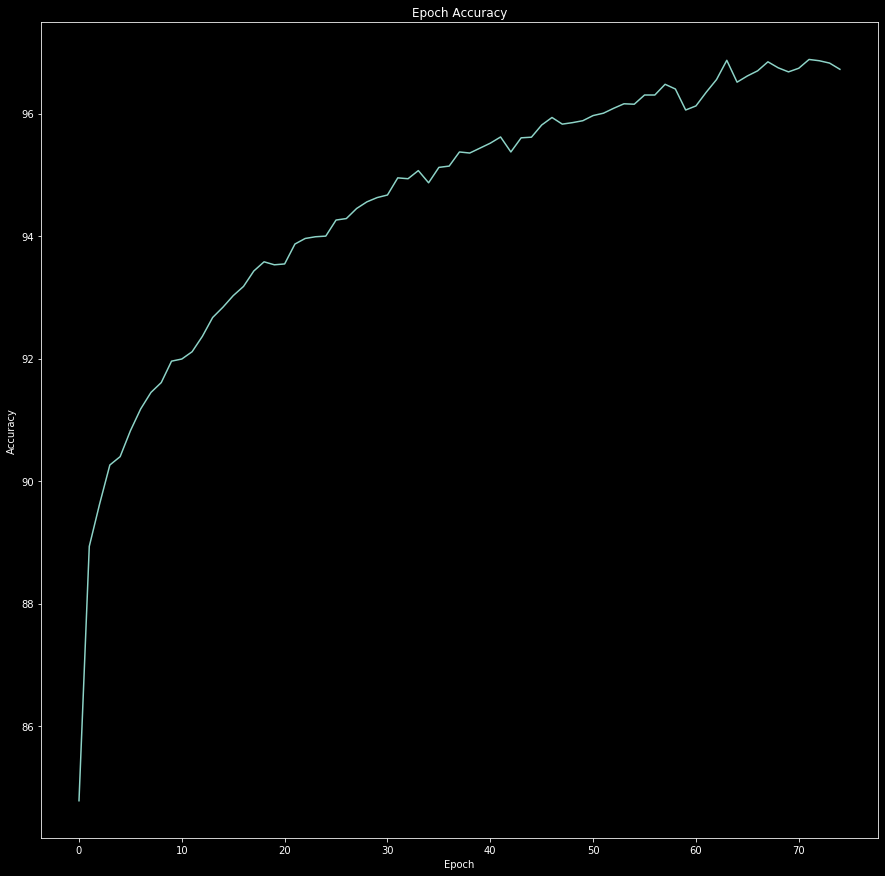

In [16]:
# plot epoch loss
fig, ax = plt.subplots(figsize=(15, 15))
plt.style.use('dark_background')
plt.plot(epoch_acc_list)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Epoch Accuracy")
plt.show()

In [17]:
# initiate a list for all predictions on xtest 
y_pred_list = []

# make sure dropout and batchnorm are operating in eval mode rather than training mode
model.eval()

# torch.no_grad() makes sure backwards propagation is not computed and lowers memory requirements of program 
with torch.no_grad():
    for X_batch in test_loader:
        
        # send xbatch to device 
        X_batch = X_batch.to(device)
        
        # predict
        y_test_pred = model(X_batch)
        
        # apply sigmoid to result 
        y_test_pred = torch.sigmoid(y_test_pred)
        
        # round off our results 
        y_pred_tag = torch.round(y_test_pred)
        
        # send y_predict to our a numpy array 
        y_pred_list.append(y_pred_tag.cpu().numpy())

# convert numpy array to list 
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
# calculate relevant statistics 

TN, FP, FN, TP = confusion_matrix(output_test, y_pred_list).ravel()
TPR = TP/(TP+FN)
FPR =1-(TN/(TN+FP))

print("True Negative= "+str(TN))
print("True Positive= "+str(TP))
print("False Negative= "+str(FN))
print("False Positive= "+str(FP))
print("True Positive Rate= "+str(TPR))
print("False Positive Rate= "+str(FPR))

True Negative= 7777
True Positive= 987
False Negative= 321
False Positive= 41
True Positive Rate= 0.7545871559633027
False Positive Rate= 0.005244308007162912


In [19]:
# calculate relevant statistics 
print(classification_report(output_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7818
           1       0.96      0.75      0.85      1308

    accuracy                           0.96      9126
   macro avg       0.96      0.87      0.91      9126
weighted avg       0.96      0.96      0.96      9126



## Attempt of LSTM neural net #2
## 1 hidden layers 